# Performance of submodels
This is a test to see how each submodel performs individually.

Spent a decent amount of time to get Random Forest to give predictions, but class imbalance gave bad results.
At the last minute, we realized that all submodels give a interval of how confident we are of said engagement, and we can therefore just round this value to give decent estimates for each single model

## Remaining todos:
* ~~Add an imputer to the prediction function? - Haven't tested if neccesary~~
* actually make decent predictions - Current ones are weird a.f... (and slow)~~
* ~~Would love to add a final row to the final results "Best possible result from metamodel"~~
   * ~Idea is that as long as ONE of the models predict ground truth, return that value for our metamodel. That should be the theoretical best I can see our model predicting. Feels like this should be easy to add, but my mind is fried by now, so not sure how to check this..

## Preprocessing

### Do some imports

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from collections import Counter

### Define scoring functions
Was an attempt to fix the gridsearch - but didn't work...

In [2]:
def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce_reversed(gt,pred):
    cross_entropy = log_loss(gt, pred, labels = [1,0])
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))], labels = [1,0])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred, labels = [1,0])
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))], labels = [1,0])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0


def compute_negative_rce(gt, pred):
    cross_entropy = log_loss(gt, pred, labels = [1,0])
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))], labels = [1,0])
    return -(1.0 - cross_entropy/strawman_cross_entropy)*100.0

custom_negative_RCE = make_scorer(compute_negative_rce)


def compute_mean_deviation_from_one(gt, pred):
    return_value = 0.0
    sum_of_ones = sum(gt)
    len_gt = len(gt)
    for idx in range(len_gt):
        if gt[idx]>0:
            return_value += np.abs(gt[idx]-pred[idx])
    return return_value/sum_of_ones

custom_negative_RCE = make_scorer(compute_negative_rce)

### Constants used later

In [3]:
engagements = ['like', 'reply', 'retweet', 'retweet_comment']
submodels = ['hashtag_similarities'
            , 'tfidf'
            , 'cb_distilled'
            , 'doc2vec'
            , 'ii_cf'
            #, 'ii_cf_short'
            , 'mf'
            , 'uu_cf'
            #, 'uu_cf_short'
           #, 'language'
            , 'user_profiles'
            ]

### Read in predictions
Yeah... Not the prettiest method, but it works I guess

In [4]:
inputpath =  "./meta_input"      # Filepath for CSV
test_path = "/prediction_on_5min"

#### Hashtag similarities

In [5]:
df_hashtag_similarities = pd.read_csv(inputpath+test_path+"/hashtag_similarities_test.csv")\
                            .rename({"HT_reply" : "reply_pred"
                                   , "HT_retweet" : "retweet_pred"
                                   , "HT_retweet_comment" : "retweet_comment_pred"
                                   , "HT_like" : "like_pred"
                                   , "reply" : "reply_true"
                                   , "retweet" : "retweet_true"
                                   , "retweet_comment" : "retweet_comment_true"
                                   , "like" : "like_true"
                                    },axis=1)\
                            .drop(["Unnamed: 0"],axis=1)\
                            .set_index(["user_id","tweet_id"])

#### TF-IDF

In [6]:
df_tfidf = pd.read_csv(inputpath + test_path + "/tfidf.csv")\
                            .rename({"tfidf_reply" : "reply_pred"
                                   , "tfidf_retweet" : "retweet_pred"
                                   , "tfidf_retweet_comment" : "retweet_comment_pred"
                                   , "tfidf_like" : "like_pred"
                                   , "reply" : "reply_true"
                                   , "retweet" : "retweet_true"
                                   , "retweet_comment" : "retweet_comment_true"
                                   , "like" : "like_true"
                                    },axis=1)\
                            .drop(["Unnamed: 0"],axis=1)\
                            .set_index(["user_id","tweet_id"])

#### CB_Distilled_5min.csv

In [7]:
df_cb_distilled = pd.read_csv(inputpath + test_path + "/CB_Distilled_5min.csv")\
                            .rename({"CB_DV_reply" : "reply_pred"
                                   , "CB_DV_retweet" : "retweet_pred"
                                   , "CB_DV_retweet_comment" : "retweet_comment_pred"
                                   , "CB_DV_like" : "like_pred"
                                   , "reply" : "reply_true"
                                   , "retweet" : "retweet_true"
                                   , "retweet_comment" : "retweet_comment_true"
                                   , "like" : "like_true"
                                   , "user" : "user_id"
                                   , "tweet" : "tweet_id"
                                    },axis=1)\
                            .drop(["Unnamed: 0"],axis=1)\
                            .drop(["index"],axis=1)\
                            .set_index(["user_id","tweet_id"])
df_cb_distilled = df_cb_distilled.iloc[1:] # Ignore one because of reasons

#### CB_Doc2Vec_5min.csv

In [8]:
df_doc2vec = pd.read_csv(inputpath + test_path + "/CB_Doc2Vec_5min.csv")\
                            .rename({"CB_DV_reply" : "reply_pred"
                                   , "CB_DV_retweet" : "retweet_pred"
                                   , "CB_DV_retweet_comment" : "retweet_comment_pred"
                                   , "CB_DV_like" : "like_pred"
                                   , "reply" : "reply_true"
                                   , "retweet" : "retweet_true"
                                   , "retweet_comment" : "retweet_comment_true"
                                   , "like" : "like_true"
                                   , "user" : "user_id"
                                   , "tweet" : "tweet_id"
                                    },axis=1)\
                            .drop(["Unnamed: 0"],axis=1)\
                            .set_index(["user_id","tweet_id"])
display(df_doc2vec)

reply_true  \
user_id                          tweet_id                                       
F761F827178FA8EDD3A0CE7F6390C11D 6EA6A9160160BC8461218A3F46A8ABCE         0.0   
D97FD68FAEFE3AEF33B5ACC6187B8520 C3066F97663A419218D12952E26555D4         0.0   
094D0012EF38A20DFD9A5B6156518A9C 9D892ABA209F0BBCC65C0003CF34E52B         0.0   
039F483B51AACC845C69AFD47EA5D9BD 4ED409F42A1F7B09280F2E3A9E274C93         0.0   
AB1DC71F9AE24F1F8081F7DAECDA9DA7 BA978CE2611B8FB4FAC8DD4477FC5F86         0.0   
...                                                                       ...   
88A1D59A5ACB3CD87AFBCB58AFB33579 FDD2D7997110248166FB05C2E8609696         0.0   
7D704E0ECA4D89F47460049DADEBBD65 BB1139C86AAB39557087F9B8BEA3D6A3         0.0   
58ED1F75F517E65F96C352C42C33E308 D03C8A65EA0A1197483C9D9051F49BD4         0.0   
1B1C8C719C1BA40D5EE7DF756ACDF0AD 24166BF0D0D45F2D811606E3417AE975         0.0   
50E428669DE88261429DE5A10FED3DDE 08F2118E055A9D8DE1C26E886A7D84F3         0.0   

                                                                   retweet_true  \
user_id                          tweet_id                                         
F761F827178FA8EDD3A0CE7F6390C11D 6EA6A9160160BC8461218A3F46A8ABCE           0.0   
D97FD68FAEFE3AEF33B5ACC6187B8520 C3066F97663A419218D12952E26555D4           0.0   
094D0012EF38A20DFD9A5B6156518A9C 9D892ABA209F0BBCC65C0003CF34E52B           1.0   
039F483B51AACC845C69AFD47EA5D9BD 4ED409F42A1F7B09280F2E3A9E274C93           1.0   
AB1DC71F9AE24F1F8081F7DAECDA9DA7 BA978CE2611B8FB4FAC8DD4477FC5F86           0.0   
...                                                                         ...   
88A1D59A5ACB3CD87AFBCB58AFB33579 FDD2D7997110248166FB05C2E8609696           0.0   
7D704E0ECA4D89F47460049DADEBBD65 BB1139C86AAB39557087F9B8BEA3D6A3           0.0   
58ED1F75F517E65F96C352C42C33E308 D03C8A65EA0A1197483C9D9051F49BD4           0.0   
1B1C8C719C1BA40D5EE7DF756ACDF0AD 24166BF0D0D45F2D811606E3417AE975           0.0   
50E428669DE88261429DE5A10FED3DDE 08F2118E055A9D8DE1C26E886A7D84F3           0.0   

                                                                   retweet_comment_true  \
user_id                          tweet_id                                                 
F761F827178FA8EDD3A0CE7F6390C11D 6EA6A9160160BC8461218A3F46A8ABCE                   0.0   
D97FD68FAEFE3AEF33B5ACC6187B8520 C3066F97663A419218D12952E26555D4                   0.0   
094D0012EF38A20DFD9A5B6156518A9C 9D892ABA209F0BBCC65C0003CF34E52B                   0.0   
039F483B51AACC845C69AFD47EA5D9BD 4ED409F42A1F7B09280F2E3A9E274C93                   0.0   
AB1DC71F9AE24F1F8081F7DAECDA9DA7 BA978CE2611B8FB4FAC8DD4477FC5F86                   0.0   
...                                                                                 ...   
88A1D59A5ACB3CD87AFBCB58AFB33579 FDD2D7997110248166FB05C2E8609696                   0.0   
7D704E0ECA4D89F47460049DADEBBD65 BB1139C86AAB39557087F9B8BEA3D6A3                   0.0   
58ED1F75F517E65F96C352C42C33E308 D03C8A65EA0A1197483C9D9051F49BD4                   0.0   
1B1C8C719C1BA40D5EE7DF756ACDF0AD 24166BF0D0D45F2D811606E3417AE975                   0.0   
50E428669DE88261429DE5A10FED3DDE 08F2118E055A9D8DE1C26E886A7D84F3                   0.0   

                                                                   like_true  \
user_id                          tweet_id                                      
F761F827178FA8EDD3A0CE7F6390C11D 6EA6A9160160BC8461218A3F46A8ABCE        1.0   
D97FD68FAEFE3AEF33B5ACC6187B8520 C3066F97663A419218D12952E26555D4        0.0   
094D0012EF38A20DFD9A5B6156518A9C 9D892ABA209F0BBCC65C0003CF34E52B        0.0   
039F483B51AACC845C69AFD47EA5D9BD 4ED409F42A1F7B09280F2E3A9E274C93        0.0   
AB1DC71F9AE24F1F8081F7DAECDA9DA7 BA978CE2611B8FB4FAC8DD4477FC5F86        1.0   
...                                                                      ...   
88A1D59A5ACB3CD87AFBCB58AFB33579 FDD2D7997110248166FB05C2E8609696        0.0   
7D704E0ECA4D89F47460049DADEBB

#### II_CF.csv

In [9]:
#II_CF.csv
df_ii_cf = pd.read_csv(inputpath + test_path + "/II_CF.csv")\
                            .rename({"II_reply" : "reply_pred"
                                   , "II_retweet" : "retweet_pred"
                                   , "II_retweet_comment" : "retweet_comment_pred"
                                   , "II_like" : "like_pred"
                                   , "reply" : "reply_true"
                                   , "retweet" : "retweet_true"
                                   , "retweet_comment" : "retweet_comment_true"
                                   , "like" : "like_true"
                                    },axis=1)\
                            .drop(["Unnamed: 0"],axis=1)\
                            .set_index(["user_id","tweet_id"])

display(df_ii_cf)

df_ii_cf.like_pred.max()

reply_pred  \
user_id                          tweet_id                                       
F761F827178FA8EDD3A0CE7F6390C11D 6EA6A9160160BC8461218A3F46A8ABCE         3.0   
D97FD68FAEFE3AEF33B5ACC6187B8520 C3066F97663A419218D12952E26555D4         5.0   
094D0012EF38A20DFD9A5B6156518A9C 9D892ABA209F0BBCC65C0003CF34E52B         1.0   
039F483B51AACC845C69AFD47EA5D9BD 4ED409F42A1F7B09280F2E3A9E274C93         4.0   
AB1DC71F9AE24F1F8081F7DAECDA9DA7 BA978CE2611B8FB4FAC8DD4477FC5F86         1.0   
...                                                                       ...   
88A1D59A5ACB3CD87AFBCB58AFB33579 FDD2D7997110248166FB05C2E8609696         1.0   
7D704E0ECA4D89F47460049DADEBBD65 BB1139C86AAB39557087F9B8BEA3D6A3         1.0   
58ED1F75F517E65F96C352C42C33E308 D03C8A65EA0A1197483C9D9051F49BD4         1.0   
1B1C8C719C1BA40D5EE7DF756ACDF0AD 24166BF0D0D45F2D811606E3417AE975         3.0   
50E428669DE88261429DE5A10FED3DDE 08F2118E055A9D8DE1C26E886A7D84F3         1.0   

                                                                   retweet_pred  \
user_id                          tweet_id                                         
F761F827178FA8EDD3A0CE7F6390C11D 6EA6A9160160BC8461218A3F46A8ABCE           3.0   
D97FD68FAEFE3AEF33B5ACC6187B8520 C3066F97663A419218D12952E26555D4           5.0   
094D0012EF38A20DFD9A5B6156518A9C 9D892ABA209F0BBCC65C0003CF34E52B           1.0   
039F483B51AACC845C69AFD47EA5D9BD 4ED409F42A1F7B09280F2E3A9E274C93           4.0   
AB1DC71F9AE24F1F8081F7DAECDA9DA7 BA978CE2611B8FB4FAC8DD4477FC5F86           1.0   
...                                                                         ...   
88A1D59A5ACB3CD87AFBCB58AFB33579 FDD2D7997110248166FB05C2E8609696           1.0   
7D704E0ECA4D89F47460049DADEBBD65 BB1139C86AAB39557087F9B8BEA3D6A3           1.0   
58ED1F75F517E65F96C352C42C33E308 D03C8A65EA0A1197483C9D9051F49BD4           1.0   
1B1C8C719C1BA40D5EE7DF756ACDF0AD 24166BF0D0D45F2D811606E3417AE975           3.0   
50E428669DE88261429DE5A10FED3DDE 08F2118E055A9D8DE1C26E886A7D84F3           1.0   

                                                                   retweet_comment_pred  \
user_id                          tweet_id                                                 
F761F827178FA8EDD3A0CE7F6390C11D 6EA6A9160160BC8461218A3F46A8ABCE                   3.0   
D97FD68FAEFE3AEF33B5ACC6187B8520 C3066F97663A419218D12952E26555D4                   5.0   
094D0012EF38A20DFD9A5B6156518A9C 9D892ABA209F0BBCC65C0003CF34E52B                   1.0   
039F483B51AACC845C69AFD47EA5D9BD 4ED409F42A1F7B09280F2E3A9E274C93                   4.0   
AB1DC71F9AE24F1F8081F7DAECDA9DA7 BA978CE2611B8FB4FAC8DD4477FC5F86                   1.0   
...                                                                                 ...   
88A1D59A5ACB3CD87AFBCB58AFB33579 FDD2D7997110248166FB05C2E8609696                   1.0   
7D704E0ECA4D89F47460049DADEBBD65 BB1139C86AAB39557087F9B8BEA3D6A3                   1.0   
58ED1F75F517E65F96C352C42C33E308 D03C8A65EA0A1197483C9D9051F49BD4                   1.0   
1B1C8C719C1BA40D5EE7DF756ACDF0AD 24166BF0D0D45F2D811606E3417AE975                   3.0   
50E428669DE88261429DE5A10FED3DDE 08F2118E055A9D8DE1C26E886A7D84F3                   1.0   

                                                                   like_pred  \
user_id                          tweet_id                                      
F761F827178FA8EDD3A0CE7F6390C11D 6EA6A9160160BC8461218A3F46A8ABCE        3.0   
D97FD68FAEFE3AEF33B5ACC6187B8520 C3066F97663A419218D12952E26555D4       25.0   
094D0012EF38A20DFD9A5B6156518A9C 9D892ABA209F0BBCC65C0003CF34E52B        1.0   
039F483B51AACC845C69AFD47EA5D9BD 4ED409F42A1F7B09280F2E3A9E274C93        4.0   
AB1DC71F9AE24F1F8081F7DAECDA9DA7 BA978CE2611B8FB4FAC8DD4477FC5F86        1.0   
...                                                                      ...   
88A1D59A5ACB3CD87AFBCB58AFB33579 FDD2D7997110248166FB05C2E8609696        1.0   
7D704E0ECA4D89F47460049DADEBB

1749.0

#### II_CF_short.csv

#### MF.csv

In [10]:
df_mf = pd.read_csv(inputpath + test_path + "/MF.csv")

df_mf = df_mf.rename({"MF_reply" : "reply_pred"
                                   , "MF_retweet" : "retweet_pred"
                                   , "MF_retweet_comment" : "retweet_comment_pred"
                                   , "MF_like" : "like_pred"
                                    },axis=1)\
                            .drop(["Unnamed: 0"],axis=1)\
                            .set_index(["user_id","tweet_id"])

# Read in random file to get indices
truth = pd.read_csv(inputpath + test_path + "/tfidf.csv")\
                        .drop(['tfidf_reply'
                             , 'tfidf_retweet'
                             , 'tfidf_retweet_comment'
                             , 'tfidf_like'
                             ],axis=1)\
                            .rename({"reply" : "reply_true"
                                   , "retweet" : "retweet_true"
                                   , "retweet_comment" : "retweet_comment_true"
                                   , "like" : "like_true"
                                    },axis=1)\
                            .drop(["Unnamed: 0"],axis=1)\
                            .set_index(["user_id","tweet_id"])

# Merge and fix indices
df_mf = pd.merge(df_mf, truth, left_index = True, right_index=True) #on = ["user_id", "tweet_id"])


#### UU_CF.csv

In [11]:
df_uu_cf = pd.read_csv(inputpath + test_path + "/UU_CF.csv")\
                            .rename({"UU_reply" : "reply_pred"
                                   , "UU_retweet" : "retweet_pred"
                                   , "UU_retweet_comment" : "retweet_comment_pred"
                                   , "UU_like" : "like_pred"
                                   , "reply" : "reply_true"
                                   , "retweet" : "retweet_true"
                                   , "retweet_comment" : "retweet_comment_true"
                                   , "like" : "like_true"
                                    },axis=1)\
                            .drop(["Unnamed: 0"],axis=1)\
                            .set_index(["user_id","tweet_id"])

#### UU_CF_short.csv

#### language_test.csv

In [12]:
df_language = pd.read_csv(inputpath + test_path + "/language_test.csv")\
                            .drop(["Unnamed: 0"],axis=1)\
                            .set_index(["user_id","tweet_id"])

#### user_profiles_5min.csv

In [13]:
df_user_profiles = pd.read_csv(inputpath + test_path + "/user_profiles_5min.csv")\
                            .rename({"Userprofile_reply" : "reply_pred"
                                   , "Userprofile_retweet" : "retweet_pred"
                                   , "Userprofile_retweet_comment" : "retweet_comment_pred"
                                   , "Userprofile_like" : "like_pred"
                                   , "reply" : "reply_true"
                                   , "retweet" : "retweet_true"
                                   , "retweet_comment" : "retweet_comment_true"
                                   , "like" : "like_true"
                                    },axis=1)\
                            .drop(["Unnamed: 0"],axis=1)\
                            .set_index(["user_id","tweet_id"])

### Check size and stuff

In [14]:
print('df_hashtag_similarities: ' + str(df_hashtag_similarities.shape))
print('df_tfidf:                ' + str(df_tfidf.shape))
print('df_cb_distilled:         ' + str(df_cb_distilled.shape))
print('df_doc2vec:              ' + str(df_doc2vec.shape))
print('df_ii_cf:                ' + str(df_ii_cf.shape))
#print('df_ii_cf_short:          ' + str(df_ii_cf_short.shape))
print('df_mf:                   ' + str(df_mf.shape))
print('df_uu_cf:                ' + str(df_uu_cf.shape))
#print('df_uu_cf_short:          ' + str(df_uu_cf_short.shape))
print('df_language:             ' + str(df_language.shape))
print('df_user_profiles:        ' + str(df_user_profiles.shape))

df_hashtag_similarities: (56714, 8)
df_tfidf:                (56714, 8)
df_cb_distilled:         (56714, 8)
df_doc2vec:              (56714, 8)
df_ii_cf:                (56714, 8)
df_mf:                   (56714, 8)
df_uu_cf:                (56714, 8)
df_language:             (56714, 1)
df_user_profiles:        (56714, 8)


### Store in single dict

In [15]:
df_dict = dict()

df_dict['hashtag_similarities'] = df_hashtag_similarities
df_dict['tfidf'] = df_tfidf
df_dict['cb_distilled'] = df_cb_distilled
df_dict['doc2vec'] = df_doc2vec
df_dict['ii_cf'] = df_ii_cf
#df_dict['ii_cf_short'] = df_ii_cf_short
df_dict['mf'] = df_mf
df_dict['uu_cf'] = df_uu_cf
#df_dict['uu_cf_short'] = df_uu_cf_short
df_dict['user_profiles'] = df_user_profiles

## Define function for calculating metric

In [16]:
def predict(df, engagement, submodel):
    # define datasets that predictions run on
    ground_truth = df[engagement + '_true'].copy()
    predictions = df[engagement + '_pred'].copy()
    
    
    # Ignore the fancy model following; this is what we are interrested in
    ground_truth.fillna(0, inplace=True)    
    predictions.fillna(0, inplace=True)
    
    cutoff_ratio = sum(ground_truth) / len(ground_truth)
    cutoff = predictions.quantile(1-cutoff_ratio)
    
    if (cutoff == predictions.max()):
        cutoff = cutoff * 0.999
    
    predictions[predictions<=cutoff] = int(0)
    predictions[predictions>cutoff] = int(1)
    
    ## define datasets that predictions run on
    #y = df[engagement_column + '_true']
    #x = df_hashtag_similarities.copy()
    #x.drop('reply_true', 1, inplace=True)
    #x.drop('retweet_true', 1, inplace=True)
    #x.drop('retweet_comment_true', 1, inplace=True)
    #x.drop('like_true', 1, inplace=True)
    
    ## Resample using SMOTE in order to fix class imbalance
    #x_sampled, y_sampled = SMOTE().fit_resample(x,y)

    ## Define a grid to run
    #param_grid = {'bootstrap': [True, False]
    #            , 'max_depth': [10, 100, 1000]
    #            , 'max_features': [1, 2, 3]
    #           #, 'min_samples_leaf': [3, 4, 5]
    #           #, 'min_samples_split': [8, 10, 12]
    #            , 'n_estimators': [2,10, 100]
    #            , 'class_weight': [None
    #                             , 'balanced'
    #                             , {0:1, 1:len(y)/sum(y)} # Wild shot in the dark. Not sure if allowed, but didn't work
    #                            ]
    #}
    
    ## Using Random Forest
    #rf = RandomForestClassifier()

    ## Run Grid_search - Scoring doesn't fix the problem
    #grid_search = GridSearchCV(estimator = rf
    #                         , param_grid = param_grid
    #                         , cv = 3
    #                         , n_jobs = -1
    #                         , verbose = 2
    #                         #, scoring=make_scorer(precision_score, greater_is_better=True)
    #                        #, scoring=make_scorer(compute_rce_reversed)#, greater_is_better=True) #YUCK!
    #                          )
    
    ## best model
    #grid_search.fit(x_sampled, y_sampled)

    ## Predictions to return
    #y_pred = grid_search.predict(x)
   
    ## Too lazy to rewrite:
    #ground_truth = y
    #predictions = y_pred
    
    # Calculate metrics
    accuracy = accuracy_score(ground_truth, predictions)
    precision = precision_score(ground_truth, predictions)
    recall = recall_score(ground_truth, predictions)
    f1 = f1_score(ground_truth, predictions)
    #rce = compute_rce(predictions, ground_truth)
    rce = compute_negative_rce(predictions, ground_truth)
    mse = mean_squared_error(predictions, ground_truth)

    res = pd.DataFrame({
          "model" : [submodel]
        , "cutoff" : [cutoff]
        , "accuracy" : [accuracy]
        , "precision" : [precision]
        , "recall" : [recall]
        , "f1" : [f1]
        , "rce" : [rce]
        , "mse" : [mse]
    })
    print(res)
    
    
    print("---------------------")
    print("Confusion Matrix:")
    print("---------")
    confusion_matrix = pd.crosstab(ground_truth, predictions, rownames=['Actual'], colnames=['Predicted'])
    print (confusion_matrix)
    print("---------------------")
    print("True vs pred distribution:")
    print("---------")
    ground_truth.hist()
    predictions.hist()
    plt.show()
    
    ## A bunch of prints when testing for only one dataset at a time. Remove from here and to 
    ## the return statement when done. This will give way too much output otherwise
    #print("---------------------")
    #print("Sampling:")
    #print("---------")
    #print('Original dataset shape %s' % Counter(y))
    #print('Resampled dataset shape %s' % Counter(y_sampled))
    
    #print("---------------------")
    #print("Best parameters found:")
    #print("---------")
    #print(grid_search.best_params_)
    
    #print("---------------------")
    #print("Most influential features:")
    #print("---------")
    #feature_scores = pd.Series(grid_search.best_estimator_.feature_importances_, index=x.columns).sort_values(ascending=False)
    #sns.barplot(x=feature_scores, y=feature_scores.index)
    #plt.xlabel('Feature Importance Score')
    #plt.ylabel('Features')
    #plt.title("Visualizing Important Features")
    #plt.show()
    
    return res

## Calculate performance for each

like
hashtag_similarities
                  model  cutoff  accuracy  precision    recall        f1  \
0  hashtag_similarities     0.0   0.93938   0.357143  0.032836  0.060142   

           rce      mse  
0  6105.450005  0.06062  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        53166  198
1.0         3240  110
---------------------
True vs pred distribution:
---------


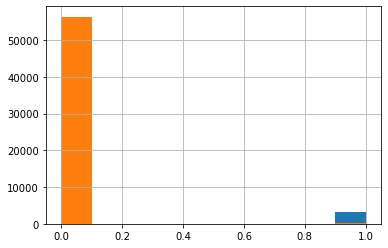

tfidf
   model    cutoff  accuracy  precision    recall        f1          rce  \
0  tfidf  0.247657  0.893113   0.095224  0.095224  0.095224  1545.212953   

        mse  
0  0.106887  
---------------------
Confusion Matrix:
---------
Predicted    0.0   1.0
Actual                
0.0        50333  3031
1.0         3031   319
---------------------
True vs pred distribution:
---------


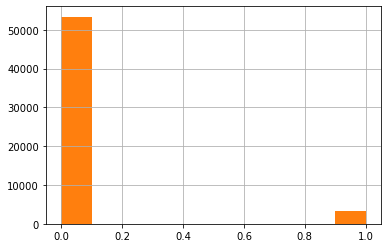

cb_distilled
          model  cutoff  accuracy  precision    recall        f1  \
0  cb_distilled     0.0  0.939503   0.260355  0.013134  0.025007   

            rce       mse  
0  10190.202067  0.060497  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        53239  125
1.0         3306   44
---------------------
True vs pred distribution:
---------


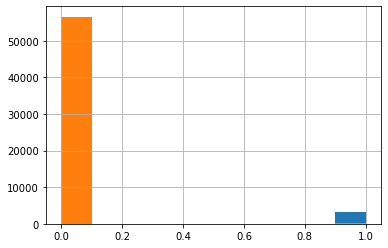

doc2vec
     model    cutoff  accuracy  precision    recall        f1          rce  \
0  doc2vec  0.114838  0.910287   0.240597  0.240597  0.240597  1280.871578   

        mse  
0  0.089713  
---------------------
Confusion Matrix:
---------
Predicted    0.0   1.0
Actual                
0.0        50820  2544
1.0         2544   806
---------------------
True vs pred distribution:
---------


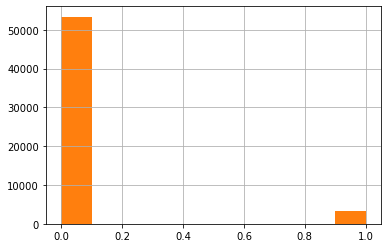

ii_cf
   model  cutoff  accuracy  precision    recall        f1         rce  \
0  ii_cf     8.0  0.892266   0.063291  0.059701  0.061444  1630.55335   

        mse  
0  0.107734  
---------------------
Confusion Matrix:
---------
Predicted    0.0   1.0
Actual                
0.0        50404  2960
1.0         3150   200
---------------------
True vs pred distribution:
---------


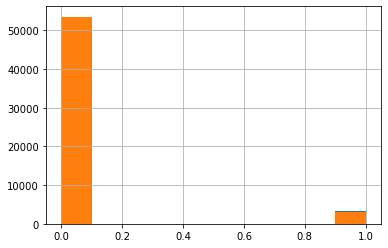

mf
  model    cutoff  accuracy  precision   recall       f1          rce  \
0    mf  0.273907  0.919914    0.32209  0.32209  0.32209  1132.688425   

        mse  
0  0.080086  
---------------------
Confusion Matrix:
---------
Predicted    0.0   1.0
Actual                
0.0        51093  2271
1.0         2271  1079
---------------------
True vs pred distribution:
---------


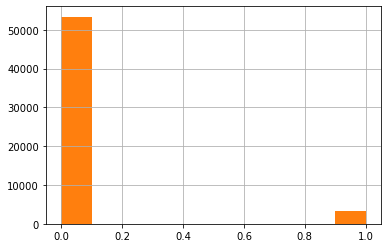

uu_cf
   model  cutoff  accuracy  precision    recall      f1          rce      mse
0  uu_cf   4.995   0.79781   0.052979  0.143582  0.0774  1487.833122  0.20219
---------------------
Confusion Matrix:
---------
Predicted    0.0   1.0
Actual                
0.0        44766  8598
1.0         2869   481
---------------------
True vs pred distribution:
---------


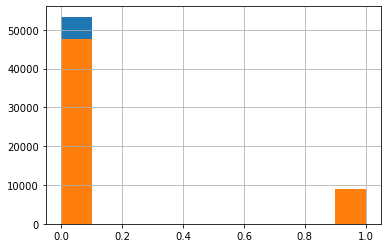

user_profiles
           model    cutoff  accuracy  precision    recall        f1  \
0  user_profiles  0.400892  0.918927   0.313731  0.313731  0.313731   

           rce       mse  
0  1147.886697  0.081073  
---------------------
Confusion Matrix:
---------
Predicted    0.0   1.0
Actual                
0          51065  2299
1           2299  1051
---------------------
True vs pred distribution:
---------


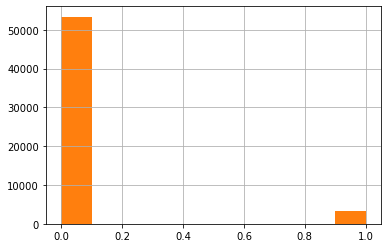

reply
hashtag_similarities
                  model  cutoff  accuracy  precision    recall        f1  \
0  hashtag_similarities     0.0  0.988398    0.00974  0.008427  0.009036   

           rce       mse  
0  1087.652045  0.011602  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        56053  305
1.0          353    3
---------------------
True vs pred distribution:
---------


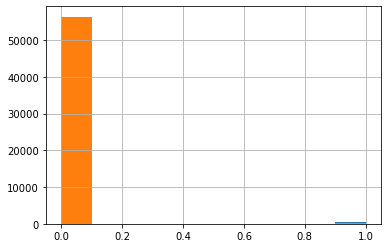

tfidf
   model    cutoff  accuracy  precision    recall        f1          rce  \
0  tfidf  0.047406  0.987869   0.031073  0.030899  0.030986  1005.270837   

        mse  
0  0.012131  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        56015  343
1.0          345   11
---------------------
True vs pred distribution:
---------


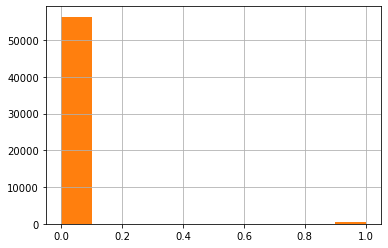

cb_distilled
          model    cutoff  accuracy  precision    recall        f1  \
0  cb_distilled  0.804021  0.987552   0.008427  0.008427  0.008427   

           rce       mse  
0  1028.866388  0.012448  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        56005  353
1.0          353    3
---------------------
True vs pred distribution:
---------


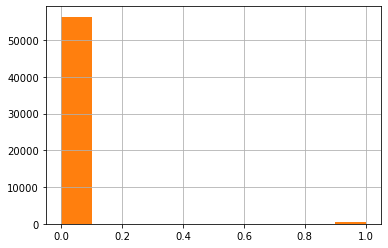

doc2vec
     model    cutoff  accuracy  precision    recall        f1         rce  \
0  doc2vec  0.177857  0.988257   0.064607  0.064607  0.064607  964.907952   

        mse  
0  0.011743  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        56025  333
1.0          333   23
---------------------
True vs pred distribution:
---------


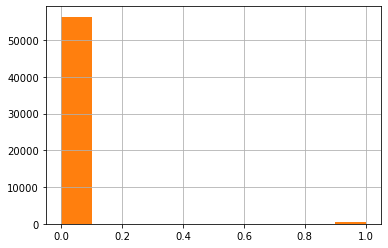

ii_cf
   model  cutoff  accuracy  precision    recall        f1          rce  \
0  ii_cf    21.0  0.987693    0.00578  0.005618  0.005698  1042.947797   

        mse  
0  0.012307  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        56014  344
1.0          354    2
---------------------
True vs pred distribution:
---------


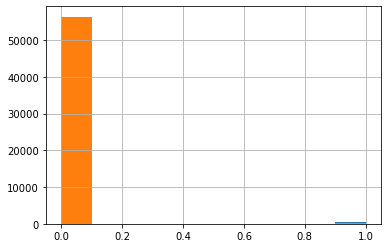

mf
  model    cutoff  accuracy  precision    recall        f1         rce  \
0    mf  0.098536  0.988927   0.117978  0.117978  0.117978  904.147438   

        mse  
0  0.011073  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        56044  314
1.0          314   42
---------------------
True vs pred distribution:
---------


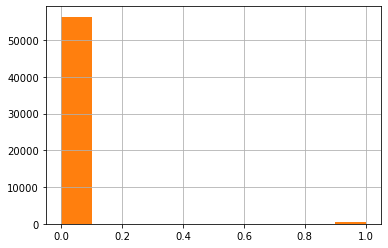

uu_cf
   model  cutoff  accuracy  precision    recall        f1         rce  \
0  uu_cf   4.995  0.976831   0.003112  0.008427  0.004545  829.289409   

        mse  
0  0.023169  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        55397  961
1.0          353    3
---------------------
True vs pred distribution:
---------


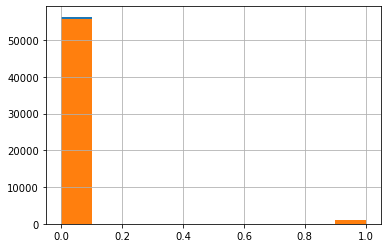

user_profiles
           model  cutoff  accuracy  precision    recall        f1         rce  \
0  user_profiles     1.0  0.988222   0.061798  0.061798  0.061798  968.105874   

        mse  
0  0.011778  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0          56024  334
1            334   22
---------------------
True vs pred distribution:
---------


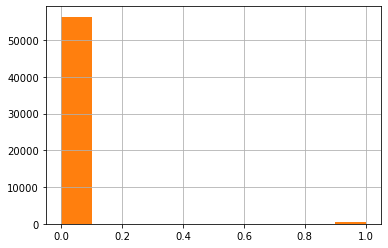

retweet
hashtag_similarities
                  model  cutoff  accuracy  precision    recall       f1  \
0  hashtag_similarities     0.0  0.980146   0.097403  0.034169  0.05059   

           rce       mse  
0  1932.375243  0.019854  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        55558  278
1.0          848   30
---------------------
True vs pred distribution:
---------


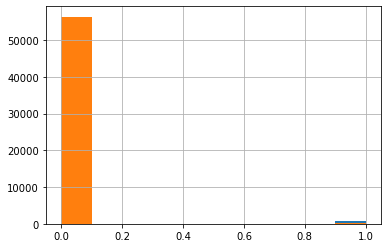

tfidf
   model    cutoff  accuracy  precision    recall        f1          rce  \
0  tfidf  0.112007  0.970995   0.062714  0.062642  0.062678  1155.170058   

        mse  
0  0.029005  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        55014  822
1.0          823   55
---------------------
True vs pred distribution:
---------


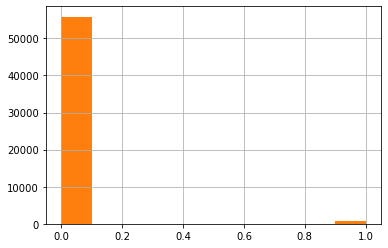

cb_distilled
          model  cutoff  accuracy  precision    recall        f1         rce  \
0  cb_distilled     0.0  0.976919    0.06288  0.035308  0.045222  1497.44377   

        mse  
0  0.023081  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        55374  462
1.0          847   31
---------------------
True vs pred distribution:
---------


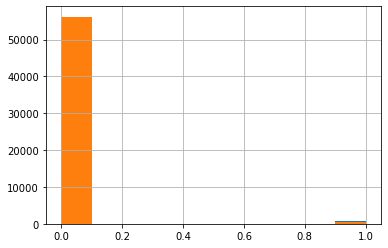

doc2vec
     model    cutoff  accuracy  precision    recall        f1         rce  \
0  doc2vec  0.091182  0.975138   0.197039  0.197039  0.197039  974.873864   

        mse  
0  0.024862  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        55131  705
1.0          705  173
---------------------
True vs pred distribution:
---------


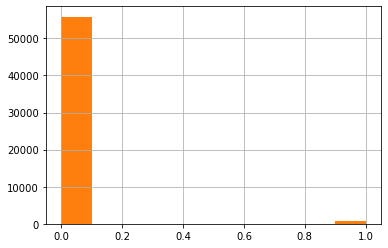

ii_cf
   model  cutoff  accuracy  precision    recall        f1          rce  \
0  ii_cf    11.0   0.97029    0.01907  0.018223  0.018637  1232.400685   

       mse  
0  0.02971  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        55013  823
1.0          862   16
---------------------
True vs pred distribution:
---------


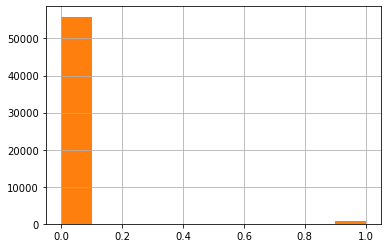

mf
  model   cutoff  accuracy  precision    recall        f1        rce       mse
0    mf  0.12011  0.975738   0.216401  0.216401  0.216401  948.95492  0.024262
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        55148  688
1.0          688  190
---------------------
True vs pred distribution:
---------


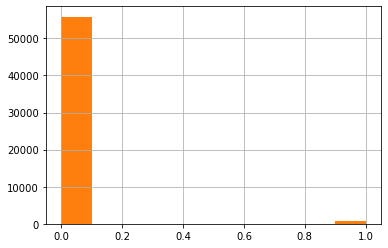

uu_cf
   model  cutoff  accuracy  precision    recall        f1          rce  \
0  uu_cf   4.995  0.955161   0.015143  0.029613  0.020039  1041.300456   

        mse  
0  0.044839  
---------------------
Confusion Matrix:
---------
Predicted    0.0   1.0
Actual                
0.0        54145  1691
1.0          852    26
---------------------
True vs pred distribution:
---------


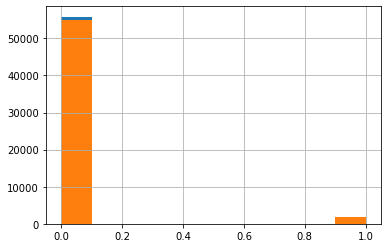

user_profiles
           model    cutoff  accuracy  precision    recall        f1  \
0  user_profiles  0.866025  0.971965   0.094533  0.094533  0.094533   

           rce       mse  
0  1112.091804  0.028035  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0          55041  795
1            795   83
---------------------
True vs pred distribution:
---------


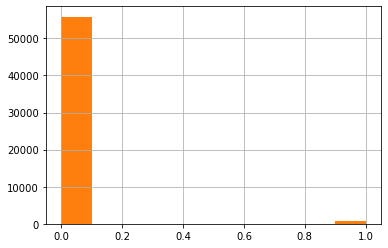

retweet_comment
hashtag_similarities
                  model    cutoff  accuracy  precision   recall       f1  \
0  hashtag_similarities  0.956299   0.99605    0.00885  0.00885  0.00885   

          rce      mse  
0  848.639657  0.00395  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        56489  112
1.0          112    1
---------------------
True vs pred distribution:
---------


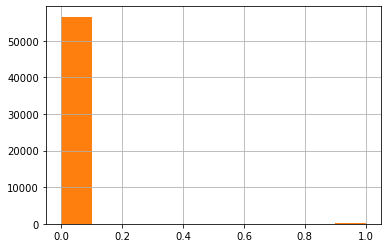

tfidf
   model    cutoff  accuracy  precision    recall        f1        rce  \
0  tfidf  0.008601  0.996086   0.017699  0.017699  0.017699  840.16966   

        mse  
0  0.003914  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        56490  111
1.0          111    2
---------------------
True vs pred distribution:
---------


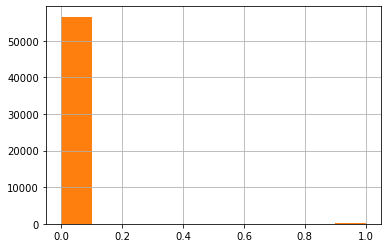

cb_distilled
          model   cutoff  accuracy  precision    recall        f1         rce  \
0  cb_distilled  0.89682  0.996121   0.026549  0.026549  0.026549  831.699663   

        mse  
0  0.003879  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        56491  110
1.0          110    3
---------------------
True vs pred distribution:
---------


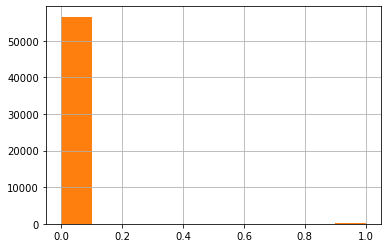

doc2vec
     model    cutoff  accuracy  precision    recall        f1         rce  \
0  doc2vec  0.087458  0.996191   0.044248  0.044248  0.044248  814.759669   

        mse  
0  0.003809  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        56493  108
1.0          108    5
---------------------
True vs pred distribution:
---------


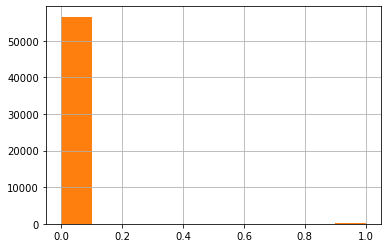

ii_cf
   model     cutoff  accuracy  precision   recall       f1         rce  \
0  ii_cf  41.001992   0.99605    0.00885  0.00885  0.00885  848.639657   

       mse  
0  0.00395  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        56489  112
1.0          112    1
---------------------
True vs pred distribution:
---------


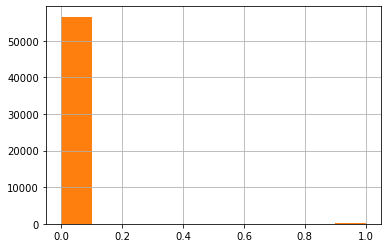

mf
  model   cutoff  accuracy  precision    recall    f1         rce      mse
0    mf  0.08319   0.99635   0.080357  0.079646  0.08  783.382861  0.00365
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        56498  103
1.0          104    9
---------------------
True vs pred distribution:
---------


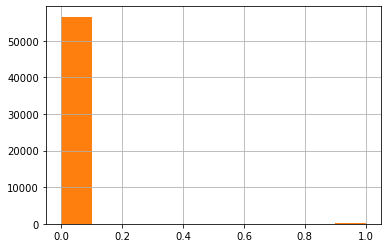

uu_cf
   model  cutoff  accuracy  precision  recall   f1         rce       mse
0  uu_cf   4.995  0.994005        0.0     0.0  0.0  693.586368  0.005995
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0.0        56374  227
1.0          113    0
---------------------
True vs pred distribution:
---------


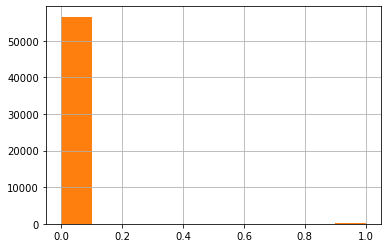

user_profiles
           model  cutoff  accuracy  precision    recall        f1         rce  \
0  user_profiles     1.0  0.996191   0.044248  0.044248  0.044248  814.759669   

        mse  
0  0.003809  
---------------------
Confusion Matrix:
---------
Predicted    0.0  1.0
Actual               
0          56493  108
1            108    5
---------------------
True vs pred distribution:
---------


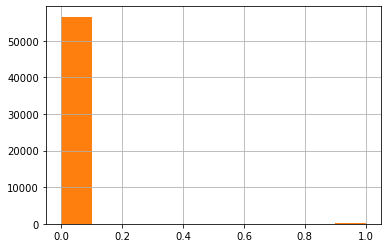

In [17]:
accuracy_measurements_dict = dict()

for engagement in engagements:
    print(engagement)
    accuracy_measurements_dict[engagement] = pd.DataFrame(columns = ['model', 'cutoff', 'accuracy', 'precision', 'recall', 'f1', 'rce', 'mse'])
    for submodel in submodels:
        print(submodel)
        res = predict(df_dict[submodel], engagement, submodel)
        
        accuracy_measurements_dict[engagement] = pd.concat([accuracy_measurements_dict[engagement], res])

# Show our final results

In [18]:
for engagement in engagements:
    print("--------------------------------")
    print("Engagement: " + engagement + ":")
    print("--------------------------------")
    display(accuracy_measurements_dict[engagement])

--------------------------------
Engagement: like:
--------------------------------


model    cutoff  accuracy  precision    recall        f1  \
0  hashtag_similarities  0.000000  0.939380   0.357143  0.032836  0.060142   
0                 tfidf  0.247657  0.893113   0.095224  0.095224  0.095224   
0          cb_distilled  0.000000  0.939503   0.260355  0.013134  0.025007   
0               doc2vec  0.114838  0.910287   0.240597  0.240597  0.240597   
0                 ii_cf  8.000000  0.892266   0.063291  0.059701  0.061444   
0                    mf  0.273907  0.919914   0.322090  0.322090  0.322090   
0                 uu_cf  4.995000  0.797810   0.052979  0.143582  0.077400   
0         user_profiles  0.400892  0.918927   0.313731  0.313731  0.313731   

            rce       mse  
0   6105.450005  0.060620  
0   1545.212953  0.106887  
0  10190.202067  0.060497  
0   1280.871578  0.089713  
0   1630.553350  0.107734  
0   1132.688425  0.080086  
0   1487.833122  0.202190  
0   1147.886697  0.081073

--------------------------------
Engagement: reply:
--------------------------------


model     cutoff  accuracy  precision    recall        f1  \
0  hashtag_similarities   0.000000  0.988398   0.009740  0.008427  0.009036   
0                 tfidf   0.047406  0.987869   0.031073  0.030899  0.030986   
0          cb_distilled   0.804021  0.987552   0.008427  0.008427  0.008427   
0               doc2vec   0.177857  0.988257   0.064607  0.064607  0.064607   
0                 ii_cf  21.000000  0.987693   0.005780  0.005618  0.005698   
0                    mf   0.098536  0.988927   0.117978  0.117978  0.117978   
0                 uu_cf   4.995000  0.976831   0.003112  0.008427  0.004545   
0         user_profiles   1.000000  0.988222   0.061798  0.061798  0.061798   

           rce       mse  
0  1087.652045  0.011602  
0  1005.270837  0.012131  
0  1028.866388  0.012448  
0   964.907952  0.011743  
0  1042.947797  0.012307  
0   904.147438  0.011073  
0   829.289409  0.023169  
0   968.105874  0.011778

--------------------------------
Engagement: retweet:
--------------------------------


model     cutoff  accuracy  precision    recall        f1  \
0  hashtag_similarities   0.000000  0.980146   0.097403  0.034169  0.050590   
0                 tfidf   0.112007  0.970995   0.062714  0.062642  0.062678   
0          cb_distilled   0.000000  0.976919   0.062880  0.035308  0.045222   
0               doc2vec   0.091182  0.975138   0.197039  0.197039  0.197039   
0                 ii_cf  11.000000  0.970290   0.019070  0.018223  0.018637   
0                    mf   0.120110  0.975738   0.216401  0.216401  0.216401   
0                 uu_cf   4.995000  0.955161   0.015143  0.029613  0.020039   
0         user_profiles   0.866025  0.971965   0.094533  0.094533  0.094533   

           rce       mse  
0  1932.375243  0.019854  
0  1155.170058  0.029005  
0  1497.443770  0.023081  
0   974.873864  0.024862  
0  1232.400685  0.029710  
0   948.954920  0.024262  
0  1041.300456  0.044839  
0  1112.091804  0.028035

--------------------------------
Engagement: retweet_comment:
--------------------------------


model     cutoff  accuracy  precision    recall        f1  \
0  hashtag_similarities   0.956299  0.996050   0.008850  0.008850  0.008850   
0                 tfidf   0.008601  0.996086   0.017699  0.017699  0.017699   
0          cb_distilled   0.896820  0.996121   0.026549  0.026549  0.026549   
0               doc2vec   0.087458  0.996191   0.044248  0.044248  0.044248   
0                 ii_cf  41.001992  0.996050   0.008850  0.008850  0.008850   
0                    mf   0.083190  0.996350   0.080357  0.079646  0.080000   
0                 uu_cf   4.995000  0.994005   0.000000  0.000000  0.000000   
0         user_profiles   1.000000  0.996191   0.044248  0.044248  0.044248   

          rce       mse  
0  848.639657  0.003950  
0  840.169660  0.003914  
0  831.699663  0.003879  
0  814.759669  0.003809  
0  848.639657  0.003950  
0  783.382861  0.003650  
0  693.586368  0.005995  
0  814.759669  0.003809

## Latex-friendly output

In [19]:
for engagement in engagements:
    print("--------------------------------")
    print("Engagement: " + engagement + ":")
    print("--------------------------------")
    #display(accuracy_measurements_dict[engagement].to_latex())
    print(accuracy_measurements_dict[engagement].to_latex())

--------------------------------
Engagement: like:
--------------------------------
\begin{tabular}{llrrrrrrr}
\toprule
{} &                 model &    cutoff &  accuracy &  precision &    recall &        f1 &           rce &       mse \\
\midrule
0 &  hashtag\_similarities &  0.000000 &  0.939380 &   0.357143 &  0.032836 &  0.060142 &   6105.450005 &  0.060620 \\
0 &                 tfidf &  0.247657 &  0.893113 &   0.095224 &  0.095224 &  0.095224 &   1545.212953 &  0.106887 \\
0 &          cb\_distilled &  0.000000 &  0.939503 &   0.260355 &  0.013134 &  0.025007 &  10190.202067 &  0.060497 \\
0 &               doc2vec &  0.114838 &  0.910287 &   0.240597 &  0.240597 &  0.240597 &   1280.871578 &  0.089713 \\
0 &                 ii\_cf &  8.000000 &  0.892266 &   0.063291 &  0.059701 &  0.061444 &   1630.553350 &  0.107734 \\
0 &                    mf &  0.273907 &  0.919914 &   0.322090 &  0.322090 &  0.322090 &   1132.688425 &  0.080086 \\
0 &                 uu\_cf &  4.995000 & 